KeyboardInterrupt: 

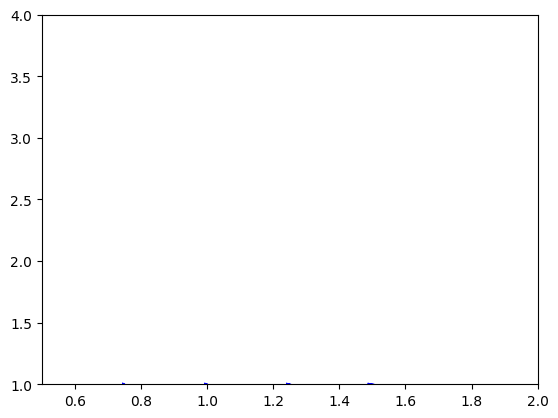

In [11]:
import numpy as np
import scipy
from scipy import integrate, stats
import matplotlib.pyplot as plt
import os
import pickle
from scipy.linalg import svd
import matplotlib.patches as patches
from sigfig import round

# Use the generalized gamma CDF from your MATLAB function
def compute_cdf_using_gengamma(r, beta, x):
    gen_gamma_cdf = lambda x: scipy.special.gammainc(beta, x ** r)
    gauss_density = lambda z: (1. / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * (z ** 2))

    integrand = lambda z: gauss_density(z) * (1 - gen_gamma_cdf((x / z) ** 2))
    res, _ = scipy.integrate.quad(integrand, -np.inf, 0)
    if x > 0:
        res = 1 - res
    return res

# Approximate KS statistic as per your previous implementation
def ks_1samp_test(subsample, cdf_func):
    # Use the KS test with a custom callable CDF function
    return stats.ks_1samp(subsample, cdf_func).statistic

# Update the CDF function to handle arrays of inputs
def compute_cdf_using_gengamma(r, beta, x):
    gen_gamma_cdf = lambda x: scipy.special.gammainc(beta, x ** r)
    gauss_density = lambda z: (1. / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * (z ** 2))

    # Define the integrand using array support for z
    def integrand(z, x):
        return gauss_density(z) * (1 - gen_gamma_cdf((x / z) ** 2))

    if isinstance(x, (np.ndarray, list)):
        # Handle array input by vectorizing the integrand
        res = np.array([scipy.integrate.quad(lambda z: integrand(z, xi), -np.inf, 0)[0] for xi in x])
        res[x > 0] = 1 - res[x > 0]  # Apply correction for positive x values
        return res
    else:
        # Handle scalar input
        res, _ = scipy.integrate.quad(lambda z: integrand(z, x), -np.inf, 0)
        if x > 0:
            res = 1 - res
        return res
def generate_points(theta, epsilon=1e-5):
    # Generate scalar values from theta using cosine and sine
    point_x = epsilon * np.cos(theta)
    point_y = epsilon * np.sin(theta)
    return point_x, point_y

# Derivative function for r using the KS test approximation
def derivative_r_ks(r, eta, epsilon=1e-5):
    def derivative_function(theta):
        # Generate scalar points based on theta
        point_x, _ = generate_points(theta, epsilon)
        
        # Generate a sample using r + epsilon (perturbation in r)
        sample_plus_epsilon = np.array([r + epsilon + point_x] * 10)  # Use 10 points as an example
        sample_original = np.array([r + point_x] * 10)

        # Define a CDF function for the KS test (handling arrays of inputs)
        cdf_func = lambda x: compute_cdf_using_gengamma(r, eta, x)

        # Calculate KS statistic difference
        ks_diff = ks_1samp_test(sample_plus_epsilon, cdf_func) - ks_1samp_test(sample_original, cdf_func)
        return ks_diff / epsilon
    return derivative_function

# Derivative function for eta using the KS test approximation
def derivative_eta_ks(r, eta, epsilon=1e-5):
    def derivative_function(theta):
        # Generate scalar points based on theta
        _, point_y = generate_points(theta, epsilon)

        # Generate a sample using eta + epsilon (perturbation in eta)
        sample_plus_epsilon = np.array([eta + epsilon + point_y] * 10)  # Use 10 points as an example
        sample_original = np.array([eta + point_y] * 10)

        # Define a CDF function for the KS test (handling arrays of inputs)
        cdf_func = lambda x: compute_cdf_using_gengamma(r, eta, x)

        # Calculate KS statistic difference
        ks_diff = ks_1samp_test(sample_plus_epsilon, cdf_func) - ks_1samp_test(sample_original, cdf_func)
        return ks_diff / epsilon
    return derivative_function


# Integrate the functions over theta to calculate the Hessian
def integrate_function_ks_r_eta(r, eta, theta_range, epsilon=1e-5):
    dr_func = derivative_r_ks(r, eta, epsilon)
    de_func = derivative_eta_ks(r, eta, epsilon)
    def integrand(theta):
        return dr_func(theta) * de_func(theta)
    result, error = integrate.quad(integrand, 0, 2 * np.pi)
    return result

def integrate_function_ks_r_r(r, eta, theta_range, epsilon=1e-5):
    dr_func = derivative_r_ks(r, eta, epsilon)
    def integrand(theta):
        return dr_func(theta) ** 2
    result, error = integrate.quad(integrand, 0, 2 * np.pi)
    return result

def integrate_function_ks_eta_eta(r, eta, theta_range, epsilon=1e-5):
    de_func = derivative_eta_ks(r, eta, epsilon)
    def integrand(theta):
        return de_func(theta) ** 2
    result, error = integrate.quad(integrand, 0, 2 * np.pi)
    return result

def hessian_ks(r, eta, theta_range, epsilon=1e-5):
    H_ks = np.array([
        [integrate_function_ks_r_r(r, eta, theta_range, epsilon),
         integrate_function_ks_r_eta(r, eta, theta_range, epsilon)],
        [integrate_function_ks_r_eta(r, eta, theta_range, epsilon),
         integrate_function_ks_eta_eta(r, eta, theta_range, epsilon)]
    ])
    return H_ks

# Visualization setup
#r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
#eta_ellipses = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
eta_ellipses = [1, 1.5, 2, 2.5, 3, 3.5, 4]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Define a range of theta values for integration
theta_range = np.linspace(0, 2 * np.pi, 100)

fig, ax = plt.subplots()
ax.set_xlim(np.min(r_ellipses), np.max(r_ellipses))
ax.set_ylim(np.min(eta_ellipses), np.max(eta_ellipses))

scale_factor = 0.0000001
pos_list = []
singular_values = []

# Loop through R_ellipses and Eta_ellipses for the ellipses
for i in range(len(r_ellipses)):
    for j in range(len(eta_ellipses)):
        H = hessian_ks(R_ellipses[i, j], Eta_ellipses[i, j], theta_range)
        
        pos_list.append(np.all(np.linalg.eigvals(H) > 0))  # Check for positive definiteness
        U, s, Vt = svd(H)
        for singular_value in s:
            singular_values.append((singular_value, R_ellipses[i, j], Eta_ellipses[i, j]))
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])
        ellipse = patches.Ellipse((R_ellipses[i, j], Eta_ellipses[i, j]), width, height, angle=angle, edgecolor='blue', facecolor='none')
        ax.add_patch(ellipse)

singular_values.sort(key=lambda x: x[0])

for value, r_val, eta_val in singular_values:
    print(f'Singular Value: {value}, r: {r_val}, eta: {eta_val}')

plt.title('Ellipses Representing the SVD of the Hessian with KS Test Approximation')
plt.xlabel('r')
plt.ylabel('eta')
plt.show()


ModuleNotFoundError: No module named 'matlab'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from utilities.testing import * 

# Assuming the utility functions are defined or imported as provided
# E.g., compute_prior_cdf, etc.

# Set reference parameters
r0 = 0.8
eta0 = 3.0

# Compute reference CDF
cdf_p0 = compute_prior_cdf(
    r=r0,
    eta=eta0,
    method='gamma_cdf',
    n_samples=1000,
    tail_bound=0.001,
    tail_percent=0.1,
    scale=1,
    use_matlab=False,
    eng=None,
    debug=False,
    enforce_assert=True,
    return_assert=False,
    return_xs=False
)

# Define ε
epsilon = 0.01

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=100)

# Initialize array to store derivatives
KS_derivatives = np.zeros_like(theta_values)

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# Evaluate reference CDF at xs
cdf_p0_values = cdf_p0(xs)

# Loop over θ values and compute derivatives
for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
    delta_r = epsilon * np.cos(theta)
    delta_eta = epsilon * np.sin(theta)
    r_prime = r0 + delta_r
    eta_prime = eta0 + delta_eta
    # Compute CDF for (r', η')
    try:
        cdf_p_prime = compute_prior_cdf(
            r=r_prime,
            eta=eta_prime,
            method='gamma_cdf',
            n_samples=1000,
            tail_bound=0.001,
            tail_percent=0.1,
            scale=1,
            use_matlab=False,
            eng=None,
            debug=False,
            enforce_assert=True,
            return_assert=False,
            return_xs=False
        )
        # Evaluate CDF at xs
        cdf_p_prime_values = cdf_p_prime(xs)
        # Compute KS statistic
        ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
        # Approximate derivative as ks_stat / epsilon
        ks_derivative = ks_stat / epsilon
        # Store derivative
        KS_derivatives[idx] = ks_derivative
    except Exception as e:
        print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
        KS_derivatives[idx] = np.nan

# Plot derivative as a function of θ
plt.figure(figsize=(10, 6))
plt.plot(theta_values, KS_derivatives, label='KS Derivative')
plt.xlabel('θ (radians)')
plt.ylabel('Derivative of KS Statistic')
plt.title('Derivative of KS Statistic with respect to ε at (r₀, η₀)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize KS statistics over a grid of (r, η)
# Define ranges for r and η around the reference point
r_values = np.linspace(r0 - 0.05, r0 + 0.05, num=50)
eta_values = np.linspace(eta0 - 0.05, eta0 + 0.05, num=50)

# Create a grid of (r, η)
R, ETA = np.meshgrid(r_values, eta_values)

# Initialize array to store KS statistics
KS_values = np.zeros_like(R)

# Loop over grid points and compute KS statistic
for i in tqdm(range(R.shape[0]), desc='Computing KS statistics over grid'):
    for j in range(R.shape[1]):
        r = R[i, j]
        eta = ETA[i, j]
        # Compute CDF for (r, η)
        try:
            cdf_p = compute_prior_cdf(
                r=r,
                eta=eta,
                method='gamma_cdf',
                n_samples=1000,
                tail_bound=0.001,
                tail_percent=0.1,
                scale=1,
                use_matlab=False,
                eng=None,
                debug=False,
                enforce_assert=True,
                return_assert=False,
                return_xs=False
            )
            # Evaluate CDF at xs
            cdf_p_values = cdf_p(xs)
            # Compute KS statistic
            ks_stat = np.max(np.abs(cdf_p_values - cdf_p0_values))
            # Store KS statistic
            KS_values[i, j] = ks_stat
        except Exception as e:
            print(f"Error computing CDF for r={r}, eta={eta}: {e}")
            KS_values[i, j] = np.nan

# Plot the contour of KS statistics
plt.figure(figsize=(10, 8))
contour = plt.contourf(R, ETA, KS_values, levels=50, cmap='viridis')
plt.colorbar(contour, label='KS Statistic')
plt.xlabel('r')
plt.ylabel('η')
plt.title('KS Statistic between p(r, η) and p(r₀, η₀)')
plt.grid(True)
plt.show()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\24340\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\24340\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\24340\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\24340\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Params: r=0.8, eta=3.0
Chebyshev bound: 94.31924566666
No tail
x=-94.32, CDF=0.00000
x=-75.42, CDF=0.00000
x=-56.52, CDF=0.00000
x=-37.61, CDF=0.00000
x=-18.71, CDF=0.00000
x=0.19, CDF=0.14883
x=19.09, CDF=0.00000
x=37.99, CDF=0.00000
x=56.89, CDF=0.00000
x=75.80, CDF=0.00000
First CDF value: 4.1947114789640103e-35
Last CDF value: 1.0
KS test statistic: 0.018763961954059383, p-value: 0.0017268034442502569


Computing derivatives: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


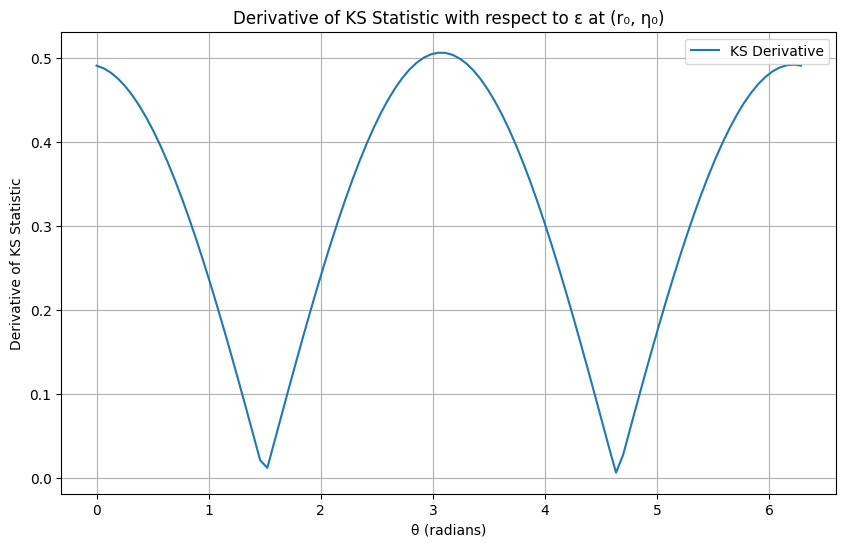

Computing KS statistics over grid: 100%|██████████| 50/50 [17:47<00:00, 21.36s/it]


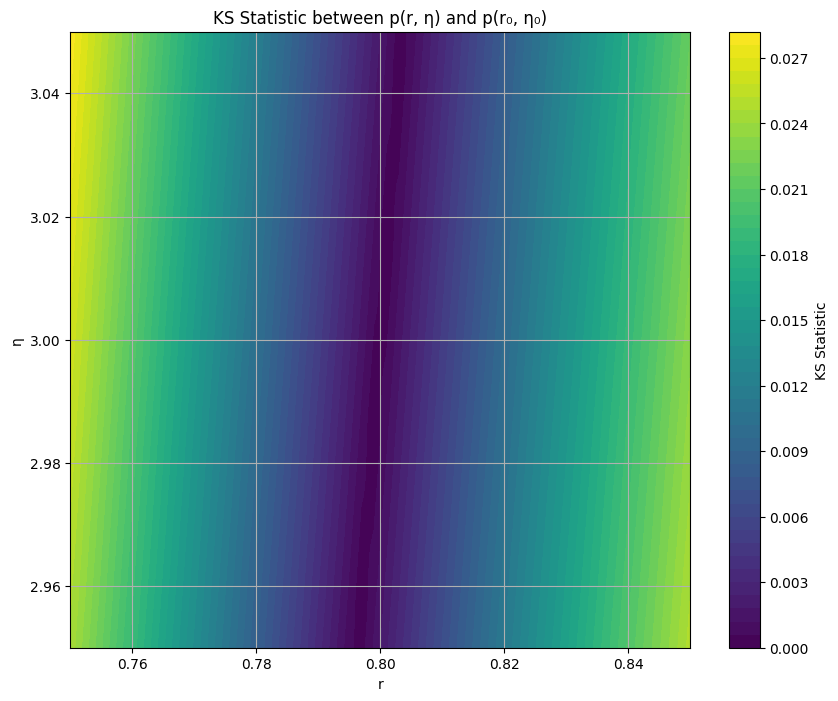

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm

# Utility Functions (Corrected)

def compute_cdf_vals(r, beta, xs, scale=1, debug=False):
    prior_cdf = np.zeros_like(xs)
    
    def integrand(theta, x):
        # Gaussian density with variance theta
        gauss = (1.0 / np.sqrt(2 * np.pi * theta)) * np.exp(-0.5 * x ** 2 / theta)
        # Generalized Gamma density for theta
        gen_gamma = (r / special.gamma(beta)) * (1.0 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        return gauss * gen_gamma

    for idx, x in enumerate(xs):
        # Integrate over theta from 0 to infinity
        result, _ = integrate.quad(integrand, 0, np.inf, args=(x,))
        prior_cdf[idx] = result
        if debug and idx % 100 == 0:
            print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")

    # Ensure CDF is cumulative
    prior_cdf = np.cumsum(prior_cdf)
    # Normalize CDF to range [0, 1]
    prior_cdf /= prior_cdf[-1]

    return prior_cdf

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1,
                                      scale=1, use_matlab=False, eng=None, enforce_assert=True,
                                      return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    # Check if beta is positive
    if beta <= 0:
        raise ValueError(f"Invalid beta value: beta={beta}. Ensure that (eta + 1.5) / r > 0.")
    var_prior = scale * special.gamma(beta + 1 / r) / special.gamma(beta)
    cheby = np.sqrt(var_prior / (tail_bound))
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: r={r}, eta={eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    # Generate xs for negative and positive sides
    xs_minus = np.concatenate((
        -np.logspace(np.log10(cheby), 2, n_tail),
        np.linspace(-x_max, 0, n_samples // 2 - n_tail)
    ))
    xs_plus = -np.flip(xs_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))

    # Compute prior CDF values at xs
    prior_cdf = compute_cdf_vals(r, beta, xs, scale=scale, debug=debug)

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")

    # Check if CDF starts near 0 and ends near 1
    if enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps):
            raise AssertionError(f"CDF at start not within tolerance: {prior_cdf[0]}")
        if not (1 - eps < prior_cdf[-1] < 1 + eps):
            raise AssertionError(f"CDF at end not within tolerance: {prior_cdf[-1]}")

    # Create spline for interpolation
    cdf_spline = interpolate.InterpolatedUnivariateSpline(xs, prior_cdf, k=3, ext='const')

    # Optional: Perform a KS test to validate the CDF
    if enforce_assert or return_assert:
        x_samples = np.sort(sample_prior(r, eta, size=10000))
        ks_stat, p_value = stats.kstest(x_samples, cdf_spline)
        if debug:
            print(f"KS test statistic: {ks_stat}, p-value: {p_value}")
        if ks_stat > 0.1:
            if enforce_assert:
                raise AssertionError(f"KS test failed with statistic: {ks_stat}")
            if return_assert:
                return (xs, None) if return_xs else None

    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, method='gamma_cdf', n_samples=1000, tail_bound=0.001,
                      tail_percent=0.1, scale=1, use_matlab=False, eng=None,
                      debug=False, enforce_assert=True, return_assert=False,
                      return_xs=False):
    if method == 'gamma_cdf':
        return compute_prior_cdf_using_gamma_cdf(
            r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound,
            tail_percent=tail_percent, scale=scale, use_matlab=use_matlab,
            eng=eng, enforce_assert=enforce_assert, return_assert=return_assert,
            return_xs=return_xs, debug=debug
        )
    else:
        raise ValueError("Invalid method. Valid options are: 'gamma_cdf'.")

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5) / r
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

# Main Script

# Set reference parameters
r0 = 0.8
eta0 = 3.0

# Compute reference CDF
cdf_p0 = compute_prior_cdf(
    r=r0,
    eta=eta0,
    method='gamma_cdf',
    n_samples=1000,
    tail_bound=0.001,
    tail_percent=0.1,
    scale=1,
    use_matlab=False,
    eng=None,
    debug=True,  # Set to True for debugging
    enforce_assert=True,
    return_assert=False,
    return_xs=False
)

# Define ε
epsilon = 0.01

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=100)

# Initialize array to store derivatives
KS_derivatives = np.zeros_like(theta_values)

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# Evaluate reference CDF at xs
cdf_p0_values = cdf_p0(xs)

# Loop over θ values and compute derivatives
for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
    delta_r = epsilon * np.cos(theta)
    delta_eta = epsilon * np.sin(theta)
    r_prime = r0 + delta_r
    eta_prime = eta0 + delta_eta
    # Compute CDF for (r', η')
    try:
        cdf_p_prime = compute_prior_cdf(
            r=r_prime,
            eta=eta_prime,
            method='gamma_cdf',
            n_samples=1000,
            tail_bound=0.001,
            tail_percent=0.1,
            scale=1,
            use_matlab=False,
            eng=None,
            debug=False,
            enforce_assert=True,
            return_assert=False,
            return_xs=False
        )
        # Evaluate CDF at xs
        cdf_p_prime_values = cdf_p_prime(xs)
        # Compute KS statistic
        ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
        # Approximate derivative as ks_stat / epsilon
        ks_derivative = ks_stat / epsilon
        # Store derivative
        KS_derivatives[idx] = ks_derivative
    except Exception as e:
        print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
        KS_derivatives[idx] = np.nan

# Plot derivative as a function of θ
plt.figure(figsize=(10, 6))
plt.plot(theta_values, KS_derivatives, label='KS Derivative')
plt.xlabel('θ (radians)')
plt.ylabel('Derivative of KS Statistic')
plt.title('Derivative of KS Statistic with respect to ε at (r₀, η₀)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize KS statistics over a grid of (r, η)
# Define ranges for r and η around the reference point
r_values = np.linspace(r0 - 0.05, r0 + 0.05, num=50)
eta_values = np.linspace(eta0 - 0.05, eta0 + 0.05, num=50)

# Create a grid of (r, η)
R, ETA = np.meshgrid(r_values, eta_values)

# Initialize array to store KS statistics
KS_values = np.zeros_like(R)

# Loop over grid points and compute KS statistic
for i in tqdm(range(R.shape[0]), desc='Computing KS statistics over grid'):
    for j in range(R.shape[1]):
        r = R[i, j]
        eta = ETA[i, j]
        # Compute CDF for (r, η)
        try:
            cdf_p = compute_prior_cdf(
                r=r,
                eta=eta,
                method='gamma_cdf',
                n_samples=1000,
                tail_bound=0.001,
                tail_percent=0.1,
                scale=1,
                use_matlab=False,
                eng=None,
                debug=False,
                enforce_assert=True,
                return_assert=False,
                return_xs=False
            )
            # Evaluate CDF at xs
            cdf_p_values = cdf_p(xs)
            # Compute KS statistic
            ks_stat = np.max(np.abs(cdf_p_values - cdf_p0_values))
            # Store KS statistic
            KS_values[i, j] = ks_stat
        except Exception as e:
            print(f"Error computing CDF for r={r}, eta={eta}: {e}")
            KS_values[i, j] = np.nan

# Plot the contour of KS statistics
plt.figure(figsize=(10, 8))
contour = plt.contourf(R, ETA, KS_values, levels=50, cmap='viridis')
plt.colorbar(contour, label='KS Statistic')
plt.xlabel('r')
plt.ylabel('η')
plt.title('KS Statistic between p(r, η) and p(r₀, η₀)')
plt.grid(True)
plt.show()


Computing KS statistics over grid: 100%|██████████| 10/10 [12:10<00:00, 73.05s/it]


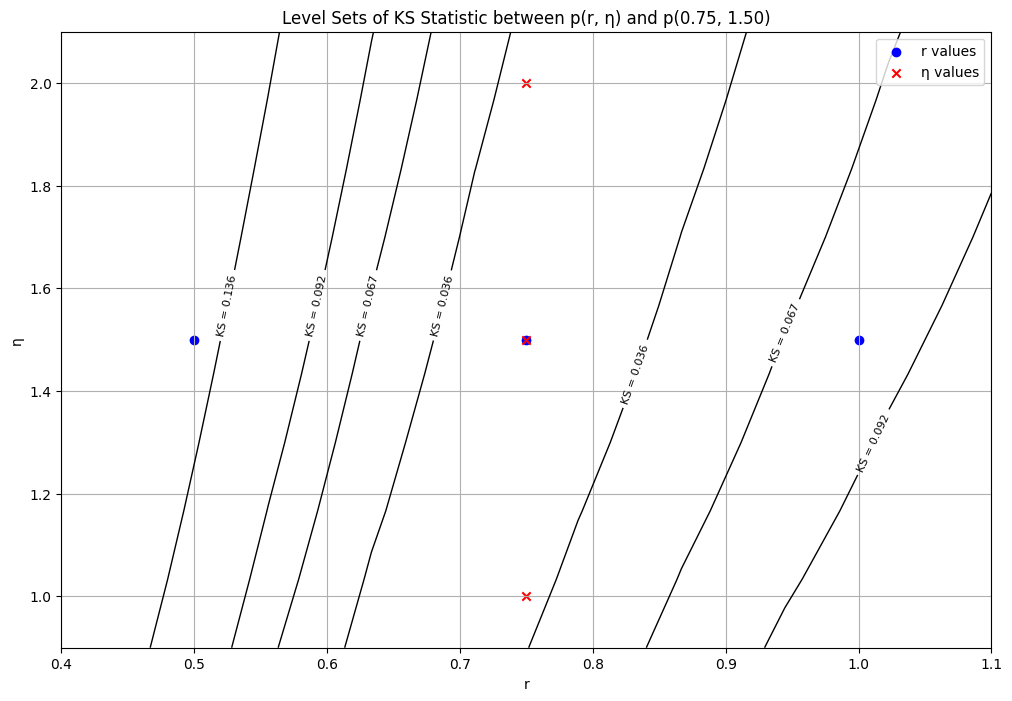

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm

# Utility Functions (Corrected)

def compute_cdf_vals(r, beta, xs, scale=1, debug=False):
    prior_cdf = np.zeros_like(xs)
    
    def gen_gamma_density(theta):
        return (r / special.gamma(beta)) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r) / scale

    for idx, x in enumerate(xs):
        def integrand(theta):
            cdf_normal = stats.norm.cdf(x / np.sqrt(theta))
            return cdf_normal * gen_gamma_density(theta)
        
        # Integrate over theta from 0 to infinity
        result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
        prior_cdf[idx] = result
        if debug and idx % 100 == 0:
            print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")
    return prior_cdf

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, scale=1, enforce_assert=True, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    # Check if beta is positive
    if beta <= 0:
        raise ValueError(f"Invalid beta value: beta={beta}. Ensure that (eta + 1.5) / r > 0.")
    
    # Generate xs over a suitable range
    xs = np.linspace(-10, 10, n_samples)
    
    # Compute prior CDF values at xs
    prior_cdf = compute_cdf_vals(r, beta, xs, scale=scale, debug=debug)
    
    # Ensure the CDF is properly normalized
    cdf_min = prior_cdf[0]
    cdf_max = prior_cdf[-1]
    prior_cdf = (prior_cdf - cdf_min) / (cdf_max - cdf_min)
    
    if enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps):
            raise AssertionError(f"CDF at start not within tolerance: {prior_cdf[0]}")
        if not (1 - eps < prior_cdf[-1] < 1 + eps):
            raise AssertionError(f"CDF at end not within tolerance: {prior_cdf[-1]}")
    
    # Create spline for interpolation
    cdf_spline = interpolate.InterpolatedUnivariateSpline(xs, prior_cdf, k=3, ext='const')
    
    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, n_samples=1000, debug=False):
    return compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=n_samples, debug=debug)

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5) / r
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

# Main Script

# Define the lists of r and eta values
r_ellipses = [0.5, 0.75, 1]
eta_ellipses = [1, 1.5, 2]

# Use the midpoints of the ranges as the reference parameters
r0 = np.mean(r_ellipses)
eta0 = np.mean(eta_ellipses)

# Compute reference CDF
cdf_p0 = compute_prior_cdf(r=r0, eta=eta0, n_samples=1000, debug=False)

# Define ranges for r and η covering r_ellipses and eta_ellipses with some padding
r_min, r_max = min(r_ellipses) - 0.1, max(r_ellipses) + 0.1
eta_min, eta_max = min(eta_ellipses) - 0.1, max(eta_ellipses) + 0.1

r_values = np.linspace(r_min, r_max, num=10)
eta_values = np.linspace(eta_min, eta_max, num=10)

# Create a grid of (r, η)
R, ETA = np.meshgrid(r_values, eta_values)

# Initialize array to store KS statistics
KS_values = np.zeros_like(R)

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 500)

# Evaluate reference CDF at xs
cdf_p0_values = cdf_p0(xs)

# Loop over grid points and compute KS statistic
for i in tqdm(range(R.shape[0]), desc='Computing KS statistics over grid'):
    for j in range(R.shape[1]):
        r = R[i, j]
        eta = ETA[i, j]
        # Compute CDF for (r, η)
        try:
            cdf_p = compute_prior_cdf(r=r, eta=eta, n_samples=500, debug=False)
            # Evaluate CDF at xs
            cdf_p_values = cdf_p(xs)
            # Compute KS statistic
            ks_stat = np.max(np.abs(cdf_p_values - cdf_p0_values))
            # Store KS statistic
            KS_values[i, j] = ks_stat
        except Exception:
            # Handle exceptions (e.g., invalid parameter combinations)
            KS_values[i, j] = np.nan

# Determine levels for the KS statistic contours
# For example, use quantiles of the KS statistic
valid_KS_values = KS_values[np.isfinite(KS_values)]
levels = np.quantile(valid_KS_values, [0.2, 0.4, 0.6, 0.8])

# Plot the contour of KS statistics using level sets
plt.figure(figsize=(12, 8))
contour = plt.contour(R, ETA, KS_values, levels=levels, colors='k', linewidths=1)
plt.clabel(contour, inline=True, fontsize=8, fmt='KS = %.3f')

# Overlay the specified r_ellipses and eta_ellipses
plt.scatter(r_ellipses, [eta0]*len(r_ellipses), color='blue', marker='o', label='r values')
plt.scatter([r0]*len(eta_ellipses), eta_ellipses, color='red', marker='x', label='η values')
plt.xlabel('r')
plt.ylabel('η')
plt.title(f'Level Sets of KS Statistic between p(r, η) and p({r0:.2f}, {eta0:.2f})')
plt.legend()
plt.grid(True)
plt.show()


Processing r0=0.5, eta0=1
Loading existing gradient data from gradient_data\gradient_data_r0.5_eta1.pkl
0.005891601376162292 0.7550188979481703
Processing r0=0.5, eta0=1.5
Loading existing gradient data from gradient_data\gradient_data_r0.5_eta1.5.pkl
0.016213460213032604 0.7182976523292028
Processing r0=0.5, eta0=2
Loading existing gradient data from gradient_data\gradient_data_r0.5_eta2.pkl
0.01945002981682542 0.6669148895859428
Processing r0=0.5, eta0=2.5
Loading existing gradient data from gradient_data\gradient_data_r0.5_eta2.5.pkl
0.011660173993291445 0.6069331137467354
Processing r0=0.75, eta0=1
Loading existing gradient data from gradient_data\gradient_data_r0.75_eta1.pkl
0.009966536106242874 0.42161836352738735
Processing r0=0.75, eta0=1.5
Loading existing gradient data from gradient_data\gradient_data_r0.75_eta1.5.pkl
0.01167455928255956 0.45854045174850144
Processing r0=0.75, eta0=2
Loading existing gradient data from gradient_data\gradient_data_r0.75_eta2.pkl
0.004884300028

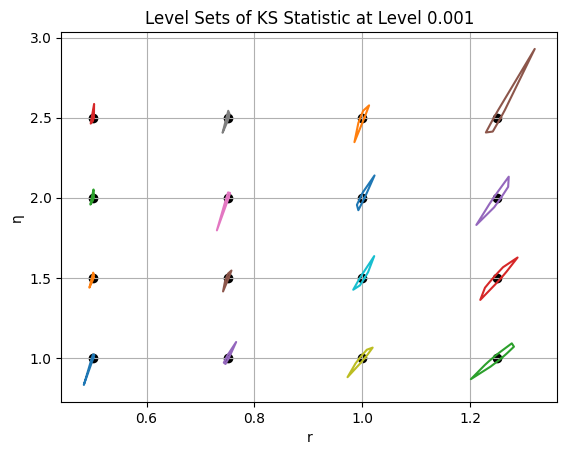

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm
import pickle
import os

# Utility Functions (Corrected)

def compute_cdf_vals(r, beta, xs, scale=1, debug=False):
    prior_cdf = np.zeros_like(xs)
    
    def gen_gamma_density(theta):
        return (r / special.gamma(beta)) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r) / scale

    for idx, x in enumerate(xs):
        def integrand(theta):
            cdf_normal = stats.norm.cdf(x / np.sqrt(theta))
            return cdf_normal * gen_gamma_density(theta)
        
        # Integrate over theta from 0 to infinity
        result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
        prior_cdf[idx] = result
        if debug and idx % 100 == 0:
            print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")
    return prior_cdf

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, scale=1, enforce_assert=True, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    # Check if beta is positive
    if beta <= 0:
        raise ValueError(f"Invalid beta value: beta={beta}. Ensure that (eta + 1.5) / r > 0.")
    
    # Generate xs over a suitable range
    xs = np.linspace(-10, 10, n_samples)
    
    # Compute prior CDF values at xs
    prior_cdf = compute_cdf_vals(r, beta, xs, scale=scale, debug=debug)
    
    # Ensure the CDF is properly normalized
    cdf_min = prior_cdf[0]
    cdf_max = prior_cdf[-1]
    prior_cdf = (prior_cdf - cdf_min) / (cdf_max - cdf_min)
    
    if enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps):
            raise AssertionError(f"CDF at start not within tolerance: {prior_cdf[0]}")
        if not (1 - eps < prior_cdf[-1] < 1 + eps):
            raise AssertionError(f"CDF at end not within tolerance: {prior_cdf[-1]}")
    
    # Create spline for interpolation
    cdf_spline = interpolate.InterpolatedUnivariateSpline(xs, prior_cdf, k=3, ext='const')
    
    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, n_samples=1000, debug=False):
    return compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=n_samples, debug=debug)

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5) / r
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

# Main Script

# Lists of r and η values
r_ellipses = [0.5, 0.75, 1, 1.25]
eta_ellipses = [1, 1.5, 2, 2.5]

# Define ε
epsilon = 0.0001

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=50)

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# KS statistic level for level set
KS_level = 0.001 #You can change this value to adjust the level set

# Directory to save gradient data
gradient_data_dir = 'gradient_data'

# Create directory if it doesn't exist
if not os.path.exists(gradient_data_dir):
    os.makedirs(gradient_data_dir)

# Loop over all (r0, η0) pairs
for r0 in r_ellipses:
    for eta0 in eta_ellipses:
        print(f"Processing r0={r0}, eta0={eta0}")
        
        # File name for gradient data
        gradient_file = os.path.join(gradient_data_dir, f'gradient_data_r{r0}_eta{eta0}.pkl')
        
        # Try to load existing gradient data
        if os.path.exists(gradient_file):
            print(f"Loading existing gradient data from {gradient_file}")
            with open(gradient_file, 'rb') as f:
                gradient_data = pickle.load(f)
            theta_values = gradient_data['theta_values']
            KS_derivatives = gradient_data['KS_derivatives']
        else:
            print(f"Computing gradient data for r0={r0}, eta0={eta0}")
            # Compute reference CDF at (r0, η0)
            try:
                cdf_p0 = compute_prior_cdf(r=r0, eta=eta0, n_samples=1000)
                cdf_p0_values = cdf_p0(xs)
            except Exception as e:
                print(f"Error computing reference CDF for r={r0}, eta={eta0}: {e}")
                continue  # Skip this pair if there's an error

            # Initialize array to store derivatives
            KS_derivatives = np.zeros_like(theta_values)
            
            # Loop over θ values and compute derivatives
            for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
                delta_r = epsilon * np.cos(theta)
                delta_eta = epsilon * np.sin(theta)
                r_prime = r0 + delta_r
                eta_prime = eta0 + delta_eta
                # Compute CDF for (r', η')
                try:
                    cdf_p_prime = compute_prior_cdf(r=r_prime, eta=eta_prime, n_samples=1000)
                    cdf_p_prime_values = cdf_p_prime(xs)
                    # Compute KS statistic
                    ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
                    # Approximate derivative as ks_stat / epsilon
                    ks_derivative = ks_stat / epsilon
                    # Store derivative
                    KS_derivatives[idx] = ks_derivative
                except Exception as e:
                    print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
                    KS_derivatives[idx] = np.nan
            
            # Save gradient data
            gradient_data = {'theta_values': theta_values, 'KS_derivatives': KS_derivatives}
            with open(gradient_file, 'wb') as f:
                pickle.dump(gradient_data, f)
        
        # Now, use the gradient data to draw a level set
        # For each θ, compute the distance s where KS_statistic equals KS_level
        # Approximate s = KS_level / KS_derivative
        s_values = KS_level / KS_derivatives  # s = KS_level / derivative
        print(min(KS_derivatives),max(KS_derivatives))
        # Handle division by zero or NaN
        s_values = np.nan_to_num(s_values, nan=np.inf, posinf=np.inf, neginf=-np.inf)
        
        # Limit s_values to a reasonable range to avoid plotting extreme values
        # max_s = 0.5  # Maximum allowed perturbation
        # s_values = np.clip(s_values, -max_s, max_s)
        
        # Compute the points on the level set
        r_values = r0 + s_values * np.cos(theta_values)
        eta_values = eta0 + s_values * np.sin(theta_values)
        
        # Remove points where s_values are infinite or NaN
        valid_indices = np.isfinite(s_values)
        r_values = r_values[valid_indices]
        eta_values = eta_values[valid_indices]
        
        # Plot the level set
        plt.plot(r_values, eta_values, label=f'r0={r0}, η0={eta0}')
        plt.scatter(r0, eta0, marker='o', color='black')  # Mark the center point

# Plot formatting
plt.xlabel('r')
plt.ylabel('η')
plt.title(f'Level Sets of KS Statistic at Level {KS_level}')
plt.grid(True)
plt.show()


In [1]:
import matlab.engine

In [2]:
eng.quit()
eng = matlab.engine.start_matlab()

Processing r0=0.5, eta0=1
Computing gradient data for r0=0.5, eta0=1


Computing derivatives: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


KS Derivatives range: 0.020537166312145638, 1.0605946442121539
Processing r0=0.5, eta0=1.5
Computing gradient data for r0=0.5, eta0=1.5


Computing derivatives: 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


KS Derivatives range: 0.03782040190913882, 1.1624961355904961
Processing r0=0.75, eta0=1
Computing gradient data for r0=0.75, eta0=1


Computing derivatives: 100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


KS Derivatives range: 0.010603436049680393, 0.42137924512131164
Processing r0=0.75, eta0=1.5
Computing gradient data for r0=0.75, eta0=1.5


Computing derivatives: 100%|██████████| 50/50 [00:53<00:00,  1.08s/it]

KS Derivatives range: 0.011337000294653343, 0.46295000311641354


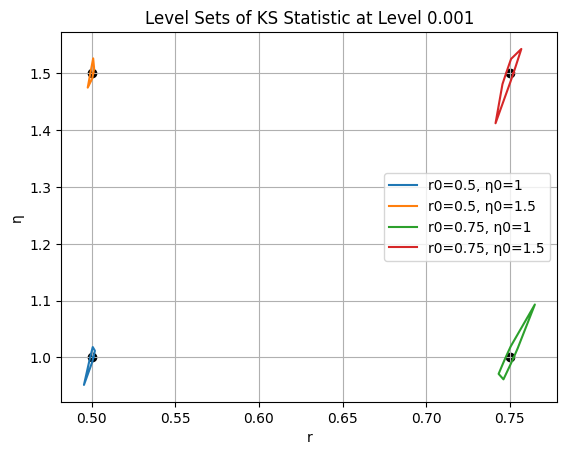

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm
import pickle
import os

# Import MATLAB Engine API for Python
import matlab.engine

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Utility Functions (Updated)

def compute_cdf_vals(r, beta, xs, use_matlab=False, debug=False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs)), desc="Computing CDF with MATLAB"):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gen_gamma_density(theta):
            return (np.abs(r) / special.gamma(beta)) * (theta) ** (r * beta - 1) * np.exp(-(theta) ** r)

        for idx, x in enumerate(xs):
            def integrand(theta):
                cdf_normal = stats.norm.cdf(x / np.sqrt(theta))
                return cdf_normal * gen_gamma_density(theta)
            # Integrate over theta from 0 to infinity
            result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
            prior_cdf[idx] = result
            if debug and idx % 100 == 0:
                print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")
    return prior_cdf

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5)/r 
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: r={r}, eta={eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab=use_matlab, debug=debug)

    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1 - np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.kstest(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.2:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, method='gamma_cdf', n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, debug=False, enforce_assert=True, return_assert=False, return_xs=False):
    if method == 'gamma_cdf':
        return compute_prior_cdf_using_gamma_cdf(r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound, tail_percent=tail_percent, scale=scale, use_matlab=use_matlab, eng=eng, enforce_assert=enforce_assert, return_assert=return_assert, return_xs=return_xs, debug=debug)
    else:
        raise ValueError("Invalid method specified.")

# Main Script

# Lists of r and η values
r_ellipses = [0.5, 0.75]
eta_ellipses = [1, 1.5]

# Define ε
epsilon = 0.00001

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=100)

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# KS statistic level for level set
KS_level = 0.001  # You can change this value to adjust the level set

# Directory to save gradient data
gradient_data_dir = 'gradient_data'

# Create directory if it doesn't exist
if not os.path.exists(gradient_data_dir):
    os.makedirs(gradient_data_dir)

# Function to format numbers for filenames
def format_number(x, multiplier):
    return int(np.round(x * multiplier))

# Loop over all (r0, η0) pairs
for r0 in r_ellipses:
    for eta0 in eta_ellipses:
        print(f"Processing r0={r0}, eta0={eta0}")
        
        # Format numbers for filenames
        r0_int = format_number(r0, 100)
        eta0_int = format_number(eta0, 100)
        epsilon_int = format_number(epsilon, 1e6)
        theta_num = len(theta_values)
        
        # File name for gradient data
        gradient_file = os.path.join(
            gradient_data_dir,
            f'gradient_data_r{r0_int}_eta{eta0_int}_eps{epsilon_int}_theta{theta_num}.pkl'
        )
        
        # Try to load existing gradient data
        if os.path.exists(gradient_file):
            print(f"Loading existing gradient data from {gradient_file}")
            with open(gradient_file, 'rb') as f:
                gradient_data = pickle.load(f)
            theta_values = gradient_data['theta_values']
            KS_derivatives = gradient_data['KS_derivatives']
        else:
            print(f"Computing gradient data for r0={r0}, eta0={eta0}")
            # Compute reference CDF at (r0, η0)
            try:
                cdf_p0 = compute_prior_cdf(r=r0, eta=eta0, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                cdf_p0_values = cdf_p0(xs)
            except Exception as e:
                print(f"Error computing reference CDF for r={r0}, eta={eta0}: {e}")
                continue  # Skip this pair if there's an error

            # Initialize array to store derivatives
            KS_derivatives = np.zeros_like(theta_values)
            
            # Loop over θ values and compute derivatives
            for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
                delta_r = epsilon * np.cos(theta)
                delta_eta = epsilon * np.sin(theta)
                r_prime = r0 + delta_r
                eta_prime = eta0 + delta_eta
                # Compute CDF for (r', η')
                try:
                    cdf_p_prime = compute_prior_cdf(r=r_prime, eta=eta_prime, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                    cdf_p_prime_values = cdf_p_prime(xs)
                    # Compute KS statistic
                    ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
                    # Approximate derivative as ks_stat / epsilon
                    ks_derivative = ks_stat / epsilon
                    # Store derivative
                    KS_derivatives[idx] = ks_derivative
                except Exception as e:
                    print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
                    KS_derivatives[idx] = np.nan
            
            # Save gradient data
            gradient_data = {
                'theta_values': theta_values,
                'KS_derivatives': KS_derivatives,
                'epsilon': epsilon,
                'theta_num': theta_num,
                'r0': r0,
                'eta0': eta0
            }
            with open(gradient_file, 'wb') as f:
                pickle.dump(gradient_data, f)
        
        # Now, use the gradient data to draw a level set
        # For each θ, compute the distance s where KS_statistic equals KS_level
        # Approximate s = KS_level / KS_derivative
        s_values = KS_level / KS_derivatives  # s = KS_level / derivative
        print(f"KS Derivatives range: {np.nanmin(KS_derivatives)}, {np.nanmax(KS_derivatives)}")
        # Handle division by zero or NaN
        s_values = np.nan_to_num(s_values, nan=np.inf, posinf=np.inf, neginf=-np.inf)
        
        # Remove infinite or NaN s_values
        valid_indices = np.isfinite(s_values)
        s_values = s_values[valid_indices]
        theta_values_valid = theta_values[valid_indices]
        
        # Compute the points on the level set
        r_values = r0 + s_values * np.cos(theta_values_valid)
        eta_values = eta0 + s_values * np.sin(theta_values_valid)
        
        # Plot the level set
        plt.plot(r_values, eta_values, label=f'r0={r0}, η0={eta0}')
        plt.scatter(r0, eta0, marker='o', color='black')  # Mark the center point

# Plot formatting
plt.xlabel('r')
plt.ylabel('η')
plt.title(f'Level Sets of KS Statistic at Level {KS_level}')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_66609/4261644105.py:154: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_66609/4261644105.py:155: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]


Processing r0=0.5, eta0=0
Loading existing gradient data from hierarchical-bayesian-model-validation/gradient_data/gradient_data_r50_eta0_eps10_theta100.pkl
KS Derivatives range: 0.022075759099210442, 0.7914887269477865
Processing r0=0.5, eta0=0.5
Loading existing gradient data from hierarchical-bayesian-model-validation/gradient_data/gradient_data_r50_eta50_eps10_theta100.pkl
KS Derivatives range: 0.013870231829749, 0.9391626459687162
Processing r0=0.5, eta0=1
Loading existing gradient data from hierarchical-bayesian-model-validation/gradient_data/gradient_data_r50_eta100_eps10_theta100.pkl
KS Derivatives range: 0.010009018214240939, 1.0604514940504295
Processing r0=0.5, eta0=1.5
Loading existing gradient data from hierarchical-bayesian-model-validation/gradient_data/gradient_data_r50_eta150_eps10_theta100.pkl
KS Derivatives range: 0.020745471407401794, 1.162211134958513
Processing r0=0.5, eta0=2
Loading existing gradient data from hierarchical-bayesian-model-validation/gradient_data/

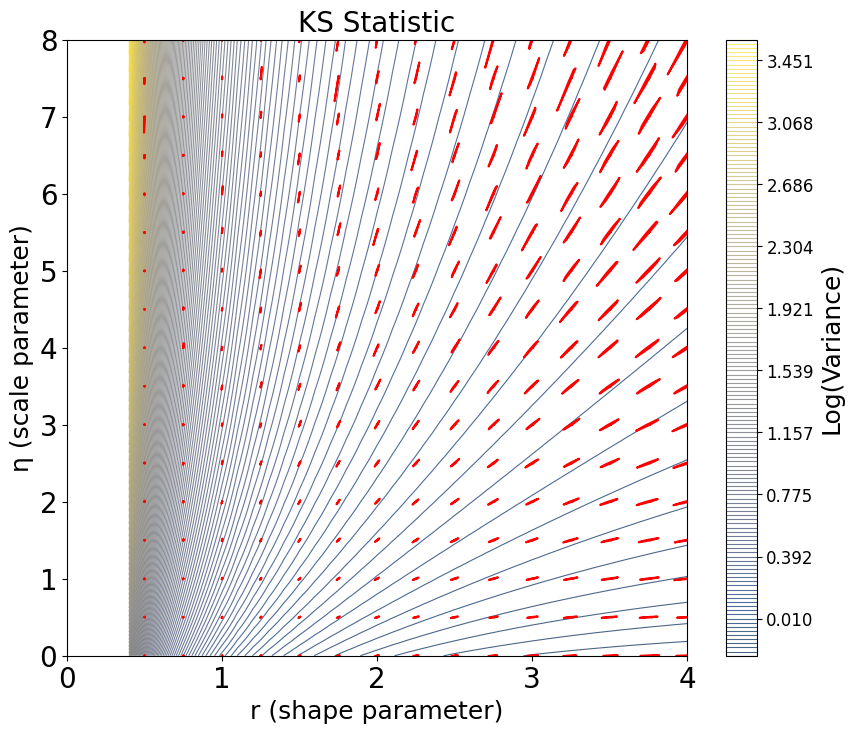

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, stats, special
from tqdm import tqdm
import pickle
import os
from sigfig import round

import git
from pathlib import Path
import os
import cv2
import numpy as np
from glob import glob

# Import MATLAB Engine API for Python
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.getcwd()
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import *
os.chdir(CWD)

# Utility Functions (Updated)

def compute_cdf_vals(r, beta, xs, use_matlab=False, debug=False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs)), desc="Computing CDF with MATLAB"):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gen_gamma_density(theta):
            return (np.abs(r) / special.gamma(beta)) * (theta) ** (r * beta - 1) * np.exp(-(theta) ** r)

        for idx, x in enumerate(xs):
            def integrand(theta):
                cdf_normal = stats.norm.cdf(x / np.sqrt(theta))
                return cdf_normal * gen_gamma_density(theta)
            # Integrate over theta from 0 to infinity
            result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
            prior_cdf[idx] = result
            if debug and idx % 100 == 0:
                print(f"x={x:.2f}, CDF={prior_cdf[idx]:.5f}")
    return prior_cdf

def sample_prior(r, eta, size=1):
    beta = (eta + 1.5)/r 
    assert beta > 0
    vars = stats.gengamma.rvs(a=beta, c=r, size=size)
    x = np.random.normal(scale=np.sqrt(vars), size=size)
    return x

def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: r={r}, eta={eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab=use_matlab, debug=debug)

    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1 - np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.kstest(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.2:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

def compute_prior_cdf(r, eta, method='gamma_cdf', n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=None, debug=False, enforce_assert=True, return_assert=False, return_xs=False):
    if method == 'gamma_cdf':
        return compute_prior_cdf_using_gamma_cdf(r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound, tail_percent=tail_percent, scale=scale, use_matlab=use_matlab, eng=eng, enforce_assert=enforce_assert, return_assert=return_assert, return_xs=return_xs, debug=debug)
    else:
        raise ValueError("Invalid method specified.")

def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5)/r 
    var_prior = scale * special.gamma(beta + 1 / r) / special.gamma(beta)
    return var_prior

# Main Script

# Lists of r and η values for level sets
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]

# Define ε
epsilon = 0.00001

# Define θ values from 0 to 2π
theta_values = np.linspace(0, 2 * np.pi, num=100)  # Granularity specified here

# Define x values for CDF evaluation
xs = np.linspace(-10, 10, 1000)

# KS statistic level for level set
KS_level = 0.0001  # You can change this value to adjust the level set

# Directory to save gradient data
gradient_data_dir = 'hierarchical-bayesian-model-validation/gradient_data'
os.makedirs(gradient_data_dir, exist_ok=True)

# Function to format numbers for filenames
def format_number(x, multiplier):
    return int(np.round(x * multiplier))

# Initialize lists for plotting level sets
all_r_values = []
all_eta_values = []

# Grid values for contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Compute variance_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Loop over all (r0, η0) pairs
for r0 in r_ellipses:
    for eta0 in eta_ellipses:
        print(f"Processing r0={r0}, eta0={eta0}")
        
        # Format numbers for filenames
        r0_int = format_number(r0, 100)
        eta0_int = format_number(eta0, 100)
        epsilon_int = format_number(epsilon, 1e6)
        theta_num = len(theta_values)
        
        # File name for gradient data
        gradient_file = os.path.join(
            gradient_data_dir,
            f'gradient_data_r{r0_int}_eta{eta0_int}_eps{epsilon_int}_theta{theta_num}.pkl'
        )
        
        # Try to load existing gradient data
        if os.path.exists(gradient_file):
            print(f"Loading existing gradient data from {gradient_file}")
            with open(gradient_file, 'rb') as f:
                gradient_data = pickle.load(f)
            theta_values = gradient_data['theta_values']
            KS_derivatives = gradient_data['KS_derivatives']
        else:
            print(f"Computing gradient data for r0={r0}, eta0={eta0}")
            # Compute reference CDF at (r0, η0)
            try:
                cdf_p0 = compute_prior_cdf(r=r0, eta=eta0, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                cdf_p0_values = cdf_p0(xs)
            except Exception as e:
                print(f"Error computing reference CDF for r={r0}, eta={eta0}: {e}")
                continue  # Skip this pair if there's an error

            # Initialize array to store derivatives
            KS_derivatives = np.zeros_like(theta_values)
            
            # Loop over θ values and compute derivatives
            for idx, theta in tqdm(enumerate(theta_values), total=len(theta_values), desc='Computing derivatives'):
                delta_r = epsilon * np.cos(theta)
                delta_eta = epsilon * np.sin(theta)
                r_prime = r0 + delta_r
                eta_prime = eta0 + delta_eta
                # Compute CDF for (r', η')
                try:
                    cdf_p_prime = compute_prior_cdf(r=r_prime, eta=eta_prime, n_samples=1000, use_matlab=True, eng=eng, debug=False)
                    cdf_p_prime_values = cdf_p_prime(xs)
                    # Compute KS statistic
                    ks_stat = np.max(np.abs(cdf_p_prime_values - cdf_p0_values))
                    # Approximate derivative as ks_stat / epsilon
                    ks_derivative = ks_stat / epsilon
                    # Store derivative
                    KS_derivatives[idx] = ks_derivative
                except Exception as e:
                    print(f"Error computing CDF for r={r_prime}, eta={eta_prime}: {e}")
                    KS_derivatives[idx] = np.nan
            
            # Save gradient data
            gradient_data = {
                'theta_values': theta_values,
                'KS_derivatives': KS_derivatives,
                'epsilon': epsilon,
                'theta_num': theta_num,
                'r0': r0,
                'eta0': eta0
            }
            with open(gradient_file, 'wb') as f:
                pickle.dump(gradient_data, f)
        
        # Now, use the gradient data to draw a level set
        # For each θ, compute the distance s where KS_statistic equals KS_level
        # Approximate s = KS_level / KS_derivative
        s_values = KS_level / KS_derivatives  # s = KS_level / derivative
        print(f"KS Derivatives range: {np.nanmin(KS_derivatives)}, {np.nanmax(KS_derivatives)}")
        # Handle division by zero or NaN
        s_values = np.nan_to_num(s_values, nan=np.inf, posinf=np.inf, neginf=-np.inf)
        
        # Remove infinite or NaN s_values
        valid_indices = np.isfinite(s_values)
        s_values = s_values[valid_indices]
        theta_values_valid = theta_values[valid_indices]
        
        # Compute the points on the level set
        r_values = r0 + s_values * np.cos(theta_values_valid)
        eta_values = eta0 + s_values * np.sin(theta_values_valid)
        
        # Store the level set points for plotting
        all_r_values.append(r_values)
        all_eta_values.append(eta_values)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('r (shape parameter)', fontsize=18)
ax.set_ylabel('η (scale parameter)', fontsize=18)
# ax.set_title(f'Level Sets of KS Statistic at Level {KS_level}\nε={epsilon}, θ samples={len(theta_values)}')
ax.set_title('KS Statistic', fontsize=20)

ax.set_xlim(0, 4)  # Set x-axis to start from 0, while keeping the upper limit automatic
ax.set_ylim(0, 8)  # Set y-axis to start from 0, while keeping the upper limit automatic


# Plot the variance prior contour
log_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)
contour = ax.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(log_levels), cmap='cividis', alpha=0.7, linewidths=0.8)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Log(Variance)', fontsize=18)
cbar.ax.tick_params(labelsize=12)

# Plot level sets
for r_values, eta_values, r0, eta0 in zip(all_r_values, all_eta_values, r_ellipses * len(eta_ellipses), np.repeat(eta_ellipses, len(r_ellipses))):
    ax.plot(r_values, eta_values, color='red', label=f'r0={r0}, η0={eta0}')


ax.tick_params(axis='both', which='major', labelsize=20)


fig.savefig('plots/ks_statistic_plot.png', bbox_inches='tight')
plt.show()
